In [1]:
# You should be able to just run the whole script to align
# Just run all cells
#this
import os
import yaml
import time
import numpy as np
import pandas as pd
import shelve
import sys
import random
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.optimize import fsolve
from scipy.interpolate import interp1d
from scipy.optimize import minimize
sys.path.append('../../')
from geecs_python_api.controls.interface import GeecsDatabase
from geecs_python_api.controls.devices.geecs_device import GeecsDevice
# from geecs_python_api.controls.experiment.experiment import Experiment



path config ..\..\..\..\..\..\user data\Configurations.INI
database name  loasis


In [2]:
GeecsDevice.exp_info = GeecsDatabase.collect_exp_info("HeaterTest")

alicat = GeecsDevice('PRC-P2-Alicat')
print(alicat.get("Pressure.device 1"))

alicat.set("Pressure.device 1", 150)

150.0


150.0

In [4]:
camera1 = GeecsDevice('CAM-CR-Beampointing1')

	Message: Device "CAM-CR-Beampointing1" not found in database
	Source:  GeecsDevice class, method "list_variables"


In [189]:
# This cell for control room setup
# DO NOT RUN

GeecsDevice.exp_info = GeecsDatabase.collect_exp_info("ControlRoom")

# set up the python objects for the geecs devices to be used in optimization
camera1 = GeecsDevice('CAM-CR-Beampointing1')
camera1.subscribe_var_values(['Target.X', 'Target.Y', 'Target2.X', 'Target2.Y'])
time.sleep(0.1)
print(camera1.state)
exposure = camera1.get('exposure')
print(f"Camera exposure is {exposure}")

target1x = camera1.get('Target.X')
target1y = camera1.get('Target.Y')
target2x = camera1.get('Target2.X')
target2y = camera1.get('Target2.Y')
print(f"Target 1 coordinates: ({int(target1x)}, {int(target1y)})")
print(f"Target 2 coordinates: ({int(target2x)}, {int(target2y)})")

centroidx = camera1.get('Centroidx')
print(centroidx)
print(camera1.state)

camera2 = GeecsDevice('CAM-CR-Beampointing2')
camera2.subscribe_var_values(['Target.X', 'Target.Y', 'Target2.X', 'Target2.Y'])
time.sleep(0.1)
print(camera2.state)
exposure = camera2.get('exposure')
print(f"Camera exposure is {exposure}")

target1x = camera2.get('Target.X')
target1y = camera2.get('Target.Y')
target2x = camera2.get('Target2.X')
target2y = camera2.get('Target2.Y')
print(f"Target 1 coordinates: ({int(target1x)}, {int(target1y)})")
print(f"Target 2 coordinates: ({int(target2x)}, {int(target2y)})")

centroidx = camera2.get('Centroidx')
print(centroidx)
print(camera2.state)

# picos = GeecsDevice('MCD-CR-Beampointing-PICOS')
# picos.subscribe_var_values(['Position.Axis 1', 'Position.Axis 2', 'Position.Axis 3', 'Position.Axis 4'])
# """For picos: beam path looks like this:
#     |      |
#     |      |
#     |      |
#     |      |
#    \|______|/
#     \      /
#    1,2     3,4 

# 1, 3 are x-dir
# 2, 4 are y-dir

# increasing pico position means increasing x, decreasing y
# """

# print("Initial pico motor positions:")
# print(f"1: {picos.get('Position.Axis 1')}")
# print(f"2: {picos.get('Position.Axis 2')}")
# print(f"3: {picos.get('Position.Axis 3')}")
# print(f"4: {picos.get('Position.Axis 4')}")
# print(picos.state)

conex = GeecsDevice('STAGE-PL1-HolyMirror')
conex.subscribe_var_values(['position'])
print("Initial conex position")
print(f"1: {conex.get('position')}")

conex2 = GeecsDevice('STAGE-PL1-HolyMirror2')
conex2.subscribe_var_values(['position'])
print("Initial conex position")
print(f"2: {conex2.get('position')}")

#this

# Negative values mean increasing mcd position decreases camera pixel value
# Camera 1 for CR
steps_per_pixel_cr1 = 26.31
steps_per_pixel_cr2 = -29.41
steps_per_pixel_cr3 = 12.04
steps_per_pixel_cr4 = -16.12

# Camera 2 for Control room (nearer camera)
steps_per_pixel_cr1 = -30.30
steps_per_pixel_cr2 = -35.71
steps_per_pixel_cr3 = -17.54
steps_per_pixel_cr4 = -22.72

steps_per_pixel_3 = 6.172
steps_per_pixel_4 = 8.70
steps_per_pixel_hex_x = 7.19e-4
steps_per_pixel_hex_y = -6.29e-4
      
# Calibrations are for cam-cr-beampointing2, which is the downstream camera
# steps_per_pixel_conex1 = 0.00014694937 # 1 inch mount
# Determined by linear regression
steps_per_pixel_conex1_camera2 = -0.0008472773555695383
steps_per_pixel_conex2_camera2 = -0.000626195225355997 # 4 inch mount

# Now for beampointing1, we need two different calibrations due to 2 different cameras
# Determined by taking ratios of movement and camera2 calibrations
steps_per_pixel_conex1_camera1 = -0.0004867208049513916
steps_per_pixel_conex2_camera1 = -0.0003148446242253497

# CR[1-4] are for testing
mcd_dict = {
#     'CR1': {
#         'device': picos, 
#         'name': 'Position.Axis 1', 
#         'alias': 'Position.Axis 1', 
#         'calib': steps_per_pixel_cr1,
#         'polyfit': None, 
#         'polyfitfine': None, 
#         'axis': 'x',
#         'min': -100000, # Software limits for beampointing
#         'max': 100000,
#        },
#     'CR2': {
#         'device': picos, 
#         'name': 'Position.Axis 2', 
#         'alias': 'Position.Axis 2', 
#         'calib': steps_per_pixel_cr2, 
#         'polyfit': None, 
#         'polyfitfine': None, 
#         'axis': 'y',
#         'min': -100000, # Software limits for beampointing
#         'max': 100000,
#         },
#     'CR3': {
#         'device': picos, 
#         'name': 'Position.Axis 3', 
#         'alias': 'Position.Axis 3', 
#         'calib': steps_per_pixel_cr3,
#         'polyfit': None, 
#         'polyfitfine': None, 
#         'axis': 'x',
#         'min': -100000, # Software limits for beampointing
#         'max': 100000,
#        },
#     'CR4': {
#         'device': picos, 
#         'name': 'Position.Axis 4', 
#         'alias': 'Position.Axis 4', 
#         'calib': steps_per_pixel_cr4,
#         'polyfit': None, 
#         'polyfitfine': None, 
#         'axis': 'y',
#         'min': -100000, # Software limits for beampointing
#         'max': 100000,
#         },
    'conex1': {
        'device': conex, 
        'name': 'position', 
        'alias': 'position', 
        'calib_cam1': steps_per_pixel_conex1_camera1,
        'calib_cam2': steps_per_pixel_conex1_camera2,
        'polyfit': None, 
        'polyfitfine': None, 
        'axis': 'x',
        'min': 0, # Software limits for beampointing
        'max': 5,
    },
    'conex2': {
        'device': conex2, 
        'name': 'position', 
        'alias': 'position', 
        'calib_cam1': steps_per_pixel_conex2_camera1,
        'calib_cam2': steps_per_pixel_conex2_camera2,
        'polyfit': None, 
        'polyfitfine': None, 
        'axis': 'x',
        'min': 0, # Software limits for beampointing
        'max': 5,
    }
}

SHOTS_TO_AVG = 1
TIME_BETWEEN_SHOTS = 0.1

CONEX_VEL = 0.5
CONEX_ACCEL = 4
CONEX_HYSTERESIS_SIZE = 0.03

{'fresh': True, 'shot number': None, 'GEECS device error': False}
Camera exposure is 0.00098
Target 1 coordinates: (655, 640)
Target 2 coordinates: (542, 319)
57.230675
{'fresh': True, 'shot number': 0, 'GEECS device error': False, 'exposure': 0.00098, 'Device Status': 'Initialized', '': 57.230675, 'device error': '', 'device preset': '', 'Target.X': 655.0, 'Target.Y': 640.0, 'Target2.X': 542.0, 'Target2.Y': 319.0}
{'fresh': True, 'shot number': None, 'GEECS device error': False}
Camera exposure is 0.02
Target 1 coordinates: (352, 597)
Target 2 coordinates: (420, 200)
690.9953
{'fresh': True, 'shot number': 0, 'GEECS device error': False, 'exposure': 0.02, 'Device Status': 'Initialized', '': 690.9953, 'device error': '', 'device preset': '', 'Target.X': 352.0, 'Target.Y': 597.0, 'Target2.X': 420.0, 'Target2.Y': 200.0}
Initial conex position
1: 3.131052
Initial conex position
2: 4.400251


In [ ]:
#this

# This cell for BELLA LPMode setup
GeecsDevice.exp_info = GeecsDatabase.collect_exp_info("Bella")
camera = GeecsDevice('CAM-PL1-LPMode')
camera.subscribe_var_values(['Target.X', 'Target.Y', 'Target2.X', 'Target2.Y'])
exposure = camera.get('exposure')
print(f"Camera exposure is {exposure}")
print(camera.state)

picos = GeecsDevice('MCD-PL1-picosOFI2')
picos.subscribe_var_values(['holy mirror horizontal', 'holy mirror vertical'])
print("Initial pico motor positions:")
print(f"3: {picos.get('Position.Axis 3')}") # holy mirror horizontal
print(f"4: {picos.get('Position.Axis 4')}") # holy mirror vertical
print(picos.state)

hexapod = GeecsDevice('HEX-PL1-2')
hexapod.subscribe_var_values(['ypos', 'zpos']) # ypos for x, zpos for y
print("Initial hexapod positions:")
print(f"ypos: {hexapod.get('ypos')}") # axicon horizontal
print(f"zpos: {hexapod.get('zpos')}") # axicon vertical
print(hexapod.state)

stage = GeecsDevice('STAGE-PL1-LPmodeLong')
stage.subscribe_var_values(['position'])
print("Initial stage positions:")
print(f"ypos: {stage.get('position')}") # stage pos
print(stage.state)

In [ ]:
#this

steps_per_pixel_3 = 6.172
steps_per_pixel_4 = 8.70
steps_per_pixel_hex_x = 7.19e-4
steps_per_pixel_hex_y = -6.29e-4

mcd_dict = {
    3: { # Holy Mirror pico
        'device': picos, 
        'name': 'Position.Axis 3', 
        'alias': 'holy mirror horizontal', 
        'calib': steps_per_pixel_3, 
        'polyfit': None, 
        'polyfitfine': None, 
        'axis': 'x',
        'min': picos.get('Position.Axis 3') - 5000, # Software limits for beampointing
        'max': picos.get('Position.Axis 3') + 5000, # You can change the +- to be larger if the beam doesn't fit
       },
    4: { # Holy mirror pico
        'device': picos, 
        'name': 'Position.Axis 4', 
        'alias': 'holy mirror vertical', 
        'calib': steps_per_pixel_4, 
        'polyfit': None, 
        'polyfitfine': None, 
        'axis': 'y', 
        'min': picos.get('Position.Axis 4') - 5000,
        'max': picos.get('Position.Axis 4') + 5000,
       },
    'hex_x': {
        'device': hexapod, 
        'name': 'ypos', 
        'alias': 'ypos', 
        'calib': steps_per_pixel_hex_x, 
        'polyfit': None, 
        'polyfitfine': None, 
        'axis': 'x',
        'min': hexapod.get('ypos') - 0.4,
        'max': hexapod.get('ypos') + 0.4,
        },
    'hex_y': {
        'device': hexapod, 
        'name': 'zpos', 
        'alias': 'zpos', 
        'calib': steps_per_pixel_hex_y, 
        'polyfit': None, 
        'polyfitfine': None, 
        'axis': 'y',
        'min': hexapod.get('zpos') - 0.4,
        'max': hexapod.get('zpos') + 0.4,
        },
}

In [5]:
#this
# Hyperparameters
SHOTS_TO_AVG = 3
TIME_BETWEEN_SHOTS = 0.1 # seconds

In [6]:
def set_with_limit(mcd, value, min_val=None, max_val=None):
    """
    Set a parameter with software limits, default is no limit
    This is a blocking function since we are setting
    
    mcd: device dictionary in mcd_dict
    value: value to set to
    min_val, max_val: you can temporarily override the software limits by specifying
    a non-null value
    
    return: actual value set
    """
    if not min_val:
        min_val = mcd['min']
    if not max_val:
        max_val = mcd['max']
        
    if min_val > max_val:
        raise Exception('min_val must be smaller than max_val')
        
    mcd['device'].set(mcd['name'], max(min_val, min(max_val, value)))
    return max(min_val, min(max_val, value))

In [7]:
# Hysteresis fix for conex
def conex_move_time(move_size, vel, accel):
    """
    Estimates the time for a conex move
    """
    t_accel = vel/accel
    t_vel = (move_size / 2 - 0.5 * accel * t_accel**2) / vel
    return (t_vel + t_accel) * 2 + 1.5 # Arbitrary extra time for move = 2

def conex_move_hysteresis(conex_name, new_pos, eps):
    """
    Moves a conex motor with hysteresis compensation in the positive direction
    conex_name: name of the conex device in the mcd_dict
    new_pos: position to move to
    eps: size of hysteresis compensation
    """
    conex = mcd_dict[conex_name]
    cur_pos = conex['device'].get(conex['name'])
    print(f"new pos: {new_pos}, cur_pos: {cur_pos}")
    set_with_limit(conex, new_pos)
    if new_pos > cur_pos: # moving in + direction
        print("forward", conex_move_time(new_pos + eps - cur_pos, CONEX_VEL, CONEX_ACCEL))
        time.sleep(conex_move_time(new_pos + eps - cur_pos, CONEX_VEL, CONEX_ACCEL))
        time.sleep(0.5) # wait a bit for the motor to turn around
        print("backwards", conex_move_time(eps, CONEX_VEL, CONEX_ACCEL))
        time.sleep(conex_move_time(eps, CONEX_VEL, CONEX_ACCEL))
    else: # moving in - direction
        time.sleep(conex_move_time(cur_pos - new_pos, CONEX_VEL, CONEX_ACCEL))

In [8]:
#this
# Beam pointing onto target
def obj_func(targetx, targety, beamx, beamy):
    return (targetx - beamx)**2 + (targety - beamy)**2

def move_random(pico_num, picos, dmin, dmax):
    """
    pico_num: an index for mcd_dict
    picos: GEECS picos object
    moves the pico between [dmin, dmax] randomly from its original position
    """
    picomotor = mcd_dict[pico_num]
    new_pos = picos.state[picomotor['name']] + random.randint(dmin, dmax)
    print(f"moving motor {pico_num} to position {new_pos}")
    picos.set(picomotor['name'], int(picos.state[picomotor['name']] + random.randint(dmin, dmax)))
    return

def get_centroid(camera, num_shots, time_between_shots):
    """
    Returns (x,y) of centroid of beam
    """
    centroidx = []
    centroidy = []
    # Average over SHOTS_TO_AVG shots
    for i in range(num_shots):
        # While loops since sometimes the camera doesn't send back a value for centroid
        centroidx1, centroidy1 = None, None
        while not isinstance(centroidx1, float):
            centroidx1 = camera.get('Centroidx')
#             print(centroidx1)
        centroidx.append(centroidx1)
        while not isinstance(centroidy1, float):
            centroidy1 = camera.get('Centroidy')
        centroidy.append(centroidy1)
        time.sleep(time_between_shots)

    centroidx = np.mean(np.array(centroidx))
    centroidy = np.mean(np.array(centroidy))
    return centroidx, centroidy

def move_onto_target(camera, obj_target, opt_rate, pico1, pico2, target, fit='linear', 
                     fine_thresh=10, hexapod_flag=True, verbose=True):
    """
    Moves a beam onto a target with pico1 and pico2
    
    camera: GEECS camera object
    obj_target: stop optimizing once obj_func < obj_target
    opt_rate: we use a linear approximation of steps per pixel
    to approximate where the target should be, but multiply by opt_rate
    pico1, pico2: choose 2 picos, they must be one in the x direction and one
    in the y direction, these should be keys in the mcd_dict
    target: an integer 1 or 2, this is which target we are pointing at
    fit: if linear, use linear calib (steps_per_pixel)
    if poly, use polynomial fit (these should be PolynomialModel instances inside mcd_dict)
    hexapod_flag: True if aligning hexapods, False if aligning picos
    (This is because hexapods take floats as inputs, and picos take ints as inputs)
    
    returns: iterations, obj_func()
    """
    if hexapod_flag:
        print("Moving a hexapod")
    else:
        print("Moving pico motors")
    
    # Helper function to calculate objective function
    def obj():
        centroidx, centroidy = get_centroid(camera, SHOTS_TO_AVG, TIME_BETWEEN_SHOTS)
            
        if target == 1:
            return obj_func(camera.state['Target.X'], camera.state['Target.Y'], 
                            centroidx, centroidy)
        elif target == 2:
            return obj_func(camera.state['Target2.X'], camera.state['Target2.Y'], 
                            centroidx, centroidy)
        else:
            raise Exception('target must be either 1 or 2')
    
    # Helper function to get target position
    def target_pos():
        if target == 1:
            return camera.state['Target.X'], camera.state['Target.Y']
        elif target == 2:
            return camera.state['Target2.X'], camera.state['Target2.Y']
        else:
            raise Exception('target must be either 1 or 2')
            
    # giving mcds more convenient names
    if mcd_dict[pico1]['axis'] == 'x' and mcd_dict[pico2]['axis'] == 'y':
        mcd_x = mcd_dict[pico1] # picomotor means the motor dictionary entry
        mcd_y = mcd_dict[pico2]
    elif mcd_dict[pico1]['axis'] == 'y' and mcd_dict[pico2]['axis'] == 'x':
        mcd_x = mcd_dict[pico2]
        mcd_y = mcd_dict[pico1]
    else:
        raise Exception('PICOs must span both x and y axes')
        
    # Move mcds until beam is close enough to target
    iterations = 0
    target_x, target_y = target_pos()
    while obj() > obj_target:
        iterations += 1
        if verbose:
            print(f"Iteration {iterations}")
        pico_x = mcd_x['device'].state[mcd_x['alias']]
        pico_y = mcd_y['device'].state[mcd_y['alias']]
        if verbose:
            print(f"Original pico position is ({int(pico_x)}, {int(pico_y)})")
        centroidx = None
        centroidy = None
        # While loops since sometimes the camera doesn't send back a value for centroid
        while not isinstance(centroidx, float):
            centroidx = camera.get('Centroidx')
        while not isinstance(centroidy, float):
            centroidy = camera.get('Centroidy')
        dx = target_x - centroidx
        dy = target_y - centroidy
        if verbose:
            print(f"original centroid position = ({centroidx}, {centroidy})")
            print(f"dx = {dx}, dy = {dy}")
        if fit == "linear":
            move_x = (dx) * mcd_x['calib'] * opt_rate
            move_y = (dy) * mcd_y['calib'] * opt_rate
        if fit == "poly":
            if np.abs(dx) > fine_thresh:
                move_x = mcd_x['polyfit'].predict_motor_move(dx) * opt_rate
            else:
                move_x = mcd_x['polyfitfine'].predict_motor_move(dx) * opt_rate
            if np.abs(dy) > fine_thresh:
                move_y = mcd_y['polyfit'].predict_motor_move(dy) * opt_rate
            else:
                move_y = mcd_y['polyfitfine'].predict_motor_move(dy) * opt_rate
        if verbose:
            if hexapod_flag:
                print(f"Moving by ({move_x}, {move_y})")
            else:
                print(f"Moving by ({int(move_x)}, {int(move_y)})")
            print(f"Moving to ({pico_x + move_x}, {pico_y + move_y})")
        if hexapod_flag: # hexapods take float moves
            set_with_limit(mcd_x, np.round(pico_x + move_x, 5))
            set_with_limit(mcd_y, np.round(pico_y + move_y, 5))
            if verbose:
                print(f"Final position is ({mcd_x['device'].state[mcd_x['alias']]}, "
                      f"{mcd_x['device'].state[mcd_y['alias']]})")
        else: # picos take int moves
            set_with_limit(mcd_x, int(pico_x + move_x))
            set_with_limit(mcd_y, int(pico_y + move_y))
            if verbose:
                print(f"Final position is ({int(mcd_x['device'].state[mcd_x['alias']])}, "
                      f"{int(mcd_x['device'].state[mcd_y['alias']])})")
        time.sleep(0.1)
        
    
    return iterations, obj()

def move_onto_target_x(camera, obj_target, opt_rate, mcd1, target):
    """
    Moves a beam onto a target with pico1 and pico2
    
    camera: GEECS camera object
    obj_target: stop optimizing once obj_func < obj_target
    opt_rate: we use a linear approximation of steps per pixel
    to approximate where the target should be, but multiply by opt_rate
    pico1, pico2: choose 2 picos, they must be one in the x direction and one
    in the y direction, these should be keys in the mcd_dict
    target: an integer 1 or 2, this is which target we are pointing at
    fit: if linear, use linear calib (steps_per_pixel)
    if poly, use polynomial fit (these should be PolynomialModel instances inside mcd_dict)
    hexapod_flag: True if aligning hexapods, False if aligning picos
    (This is because hexapods take floats as inputs, and picos take ints as inputs)
    
    returns: iterations, obj_func()
    """
    
    # Helper function to calculate objective function
    def obj():
        centroidx, centroidy = get_centroid(camera, SHOTS_TO_AVG, TIME_BETWEEN_SHOTS)
            
        if target == 1:
            return (camera.state['Target.X'] - centroidx)**2
        elif target == 2:
            return (camera.state['Target2.X'] - centroidx)**2
        else:
            raise Exception('target must be either 1 or 2')
    
    # Helper function to get target position
    def target_pos():
        if target == 1:
            return camera.state['Target.X'], camera.state['Target.Y']
        elif target == 2:
            return camera.state['Target2.X'], camera.state['Target2.Y']
        else:
            raise Exception('target must be either 1 or 2')
    
    mcd_x = mcd_dict[mcd1]
        
    # Move mcds until beam is close enough to target
    iterations = 0
    target_x, target_y = target_pos()
    while obj() > obj_target:
        iterations += 1
        print(f"Iteration {iterations}")
        pico_x = mcd_x['device'].state[mcd_x['alias']]
        print(f"Original pico position is ({float(pico_x)})")
        centroidx = None
        # While loops since sometimes the camera doesn't send back a value for centroid
        while not isinstance(centroidx, float):
            centroidx = camera.get('Centroidx')
        dx = target_x - centroidx
        print(f"original centroid position = ({centroidx})")
        print(f"dx = {dx}")
        move_x = (dx) * mcd_x['calib'] * opt_rate
        conex_move_hysteresis(mcd1, np.round(pico_x + move_x, 5), CONEX_HYSTERESIS_SIZE)
        
        print(f"Final position is ({mcd_x['device'].state[mcd_x['alias']]})")
        time.sleep(0.1)
        
    
    return iterations, obj()
    
    

In [9]:
# conex_move_hysteresis('conex1', 3.44, CONEX_HYSTERESIS_SIZE)

In [10]:
# move_onto_target_x(camera1, 9, 1, 'conex1', 1)

In [11]:
# Next few cells are to calibrate a polynomial fit for picos,
# you don't need these

# class PolynomialModel(object):
#     """Fits moves with polynomial fit"""

#     def __init__(self, n, df):
#         """
#         Parameters:
#         -----------
#         n: degree of the polynomial fit
#         df: pandas dataframe
#         """
#         # Extract data from dataframe
#         self.motor_shifts = np.diff(df['motor_positions'])
#         self.beam_shifts = np.diff(df['beam_positions'])
#         # Fit with polynomial
#         self.n = n
#         self.poly_coefs = np.polyfit(self.motor_shifts, self.beam_shifts, n)

#     def evaluate(self, x):
#         """
#         x: array-like
#         """
#         return sum([ self.poly_coefs[-p-1]*x**p for p in range(self.n+1) ])

#     def plot(self, x=None, color='k'):
#         if x is None:
#             x = np.linspace(-10000, 10000, 100)
#         y = self.evaluate(x)
#         plt.plot(self.motor_shifts, self.beam_shifts, '.')
#         plt.plot(x, y, color=color, ls='--')
#         plt.xlabel('Motor move (steps)')
#         plt.ylabel('Beam shift (pixels)')

#     def predict_motor_move(self, beam_shift):
#         f = lambda x:self.evaluate(x) - beam_shift
#         motor_move = fsolve( f, x0=0., xtol=0.3 )
#         return int(motor_move[0])

In [12]:
# For polynomial fitting, do not use

# def get_calibration_data(n_points, camera, picos, pico_num, file, motor_min, motor_max):
#     """
#     n_points: number of data points to take
#     camera: GEECS camera object
#     picos: GEECS picos object
#     pico_num: an integer (1-4), used as a key for picos_dict
#     file: csv file to save data to
#     motor_min, motor max: motor positions are randomly generated between [motor_min, motor_max]
#     """
#     motor_pos = np.zeros(n_points)
#     beam_pos = np.zeros(n_points)
#     pico_motor = picos_dict[pico_num]
#     for i in range(n_points):
#         new_pos = random.randint(motor_min, motor_max)
#         motor_pos[i] = new_pos
#         picos.set(pico_motor['name'], new_pos)
#         time.sleep(0.25)
#         if pico_motor['axis'] == 'x':
#             beam_pos[i] = camera.get('Centroidx')
#         elif pico_motor['axis'] == 'y':
#             beam_pos[i] = camera.get('Centroidy')
    
#     df = pd.DataFrame({'motor_positions': motor_pos, 'beam_positions': beam_pos})
#     df.to_csv(file)
        

In [13]:
# get_calibration_data(100, camera, picos, 3, "calibration/pico3.csv", -2000, 2000)
# get_calibration_data(100, camera, picos, 4, "calibration/pico4.csv", -2000, 2000)
# get_calibration_data(100, camera, picos, 3, "calibration/pico3fine.csv", -200, 200)
# get_calibration_data(100, camera, picos, 4, "calibration/pico4fine.csv", -200, 200)

In [14]:
# df = pd.read_csv("calibration/pico3.csv")
# pico3fit = PolynomialModel(3, df)
# pico3fit.plot(np.linspace(-4000, 4000))
# plt.show()

# df = pd.read_csv("calibration/pico4.csv")
# pico4fit = PolynomialModel(3, df)
# pico4fit.plot(np.linspace(-4000, 4000))
# plt.show()

# df = pd.read_csv("calibration/pico3fine.csv")
# pico3fitfine = PolynomialModel(3, df)
# pico3fitfine.plot(np.linspace(-400, 400))
# plt.show()

# df = pd.read_csv("calibration/pico4fine.csv")
# pico4fitfine = PolynomialModel(3, df)
# pico4fitfine.plot(np.linspace(-400, 400))
# plt.show()

In [15]:
# picos_dict[3]['polyfit'] = pico3fit
# picos_dict[4]['polyfit'] = pico4fit
# picos_dict[3]['polyfitfine'] = pico3fitfine
# picos_dict[4]['polyfitfine'] = pico4fitfine

In [16]:
# print(picos_dict[3]['polyfit'].predict_motor_move(-7))
# print(picos_dict[3]['polyfitfine'].predict_motor_move(-3.9924))
# print(picos_dict[3]['polyfit'].poly_coefs)
# print(picos_dict[3]['polyfitfine'].poly_coefs)
# print(picos_dict[4]['polyfit'].predict_motor_move(camera.state['Target.Y'] - camera.get('Centroidy')))

In [17]:
#this
def align_2_targets(mcd1, mcd2, mcd1hex, mcd2hex, camera, obj_target, 
                    opt_rate, fit='linear', fit_thresh=10):
    """
    Align to the further upstream position first (larger stage position)
    mcd1 should be picos and mcd2 should be hexapod in 1BL and 2BL
    
    Stage positions are extracted from crosshair label names
    
    This function assumes higher stage pos = further upstream
    
    mcd1: list like object of 2 labels to control motion control device 1
    This mcd should correspond to crosshair 1
    mcd2: list like object of 2 labels to control motion control device 2
    This mcd should correspond to crosshair 2
    mcd1hex, mcd2hex: True if they are hexapods, False if they aren't
    camera: GEECS camera object
    picos: GEECS picos object
    obj_target: stop optimizing once obj_func < obj_target
    opt_rate: we use a linear approximation of steps per pixel
    to approximate where the target should be, but multiply by opt_rate
    fit: if linear, use linear calib (steps_per_pixel)
    if poly, use polynomial fit (these should be PolynomialModel instances inside picos_dict)
    fit_thresh: threshold between fine and rough poly fits
    """
    stage_pos1_name = camera.get('Crosshair.Label1')
    stage_pos2_name = camera.get('Crosshair.Label2')
    # Extracting position 
    stage_pos1 = float(''.join([i for i in stage_pos1_name.split() if (i.isdigit() or i == '.')]))
    stage_pos2 = float(''.join([i for i in stage_pos2_name.split() if (i.isdigit() or i == '.')]))
    
    stage_upstream = max(stage_pos1, stage_pos2)
    stage_downstream = min(stage_pos1, stage_pos2)
    
    upstream_target = 1 if stage_pos1 > stage_pos2 else 2
    downstream_target = 1 if stage_pos1 < stage_pos2 else 2
    
    mcd_upstream = mcd1 if stage_pos1 > stage_pos2 else mcd2
    mcd_downstream = mcd1 if stage_pos1 < stage_pos2 else mcd2
    
    hex_flag_upstream = mcd1hex if stage_pos1 > stage_pos2 else mcd2hex
    hex_flag_downstream = mcd1hex if stage_pos1 < stage_pos2 else mcd2hex
    
    upstream_aligned, downstream_aligned = False, False
    while not (upstream_aligned and downstream_aligned):
        # Align to upstream first
        stage.set('position', stage_upstream)
        print(f"Stage position moved to {stage_upstream}")
        print("Moving mcd1")
        iterations, _ = move_onto_target(camera, obj_target, opt_rate, *mcd_upstream, upstream_target, 
                                         fit='linear', hexapod_flag=hex_flag_upstream)
        upstream_aligned = True
        if iterations > 0:
            downstream_aligned = False
        print('\n\n')
        
        stage.set('position', stage_downstream)
        print(f"Stage position moved to {stage_downstream}")
        print("Moving mcd2")
        iterations, _ = move_onto_target(camera, obj_target, opt_rate, *mcd_downstream, downstream_target, 
                                         fit='linear', hexapod_flag=hex_flag_downstream)
        downstream_aligned = True
        if iterations > 0:
            upstream_aligned = False
            
        print("\n\n")
        
    return
    

In [18]:
# NOT TESTED, DO NOT USE

def align_2_targets_at_once(mcd1, mcd2, mcd1hex, mcd2hex, camera, obj_target, 
                            opt_rate, stage_pos1, stage_pos2, 
                            calib_1_length, calib_2_length, fit='linear', fit_thresh=10):
    """
    Uses 2 different calibrations to align to 2 targets at once
    
    mcd1: list like object of 2 labels to control motion control device 1
    mcd2: list like object of 2 labels to control motion control device 2
    mcd1hex, mcd2hex: True if they are hexapods, False if they aren't
    camera: GEECS camera object
    picos: GEECS picos object
    obj_target: stop optimizing once obj_func < obj_target
    opt_rate: we use a linear approximation of steps per pixel
    to approximate where the target should be, but multiply by opt_rate
    stage_pos1: should correspond to target1
    stage_pos2: should correspond to target2
    STAGE_POS1 SHOULD BE FURTHER DOWNSTREAM THAN STAGE_POS2
    calib_1_length: path length from mcd1 to stage_pos1
    calib_2_length: path length from mcd2 to stage_pos1
    fit: if linear, use linear calib (steps_per_pixel)
    if poly, use polynomial fit (these should be PolynomialModel instances inside picos_dict)
    fit_thresh: threshold between fine and rough poly fits
    """
    # x1 = a1 * hex_x + b1 * pico_x
    # x2 = a2 * hex_x + b2 * pico_x
    # Solve for hex x and pico x
    while True:
        stage.set('position', stage_pos1)
        centroid1_x, centroid1_y = get_centroid(camera, SHOTS_TO_AVG, TIME_BETWEEN_SHOTS)
        stage.set('position', stage_pos2)
        centroid2_x, centroid2_y = get_centroid(camera, SHOTS_TO_AVG, TIME_BETWEEN_SHOTS)

        for mcd in mcd1:
            if mcd['axis'] == 'x':
                calib1_pos1_x = mcd['calib']
                mcd1_x = mcd
            if mcd['axis'] == 'y':
                calib1_pos1_y = mcd['calib']
                mcd1_y = mcd
        for mcd in mcd2:
            if mcd['axis'] == 'x':
                calib2_pos1_x = mcd['calib']
                mcd2_x = mcd
            if mcd['axis'] == 'y':
                calib2_pos1_y = mcd['calib']
                mcd2_y = mcd

        calib1_pos2_x = calib1_pos1_x * (calib1_length + np.abs(stage_pos1 - stage_pos2)) / calib1_length
        calib1_pos2_y = calib1_pos1_y * (calib1_length + np.abs(stage_pos1 - stage_pos2)) / calib1_length
        calib2_pos2_x = calib2_pos1_x * (calib2_length + np.abs(stage_pos1 - stage_pos2)) / calib2_length
        calib2_pos2_y = calib2_pos1_y * (calib2_length + np.abs(stage_pos1 - stage_pos2)) / calib2_length

        # X matrix equation (A * \vec{pos} = \vec{b})
        # A is matrix of calibrations
        # pos = positions/values of mcds
        # b = pixel difference in target vs centroid
        # Must do this for x and y direction

        # x-dir
        A = 1 / np.array([
            [calib1_pos1_x, calib2_pos1_x],
            [calib1_pos2_x, calib2_pos2_x]
        ]) # take reciprocal because calib numbers in steps/pixel instead of pixels/step
        b = np.array([
            [centroid1_x - camera.state['Target.X']], [centroid2_x - camera.state['Target2.X']]
        ])
        pos = np.matmul(np.linalg.inv(A), b)
        mcd1_move_x = pos[0][0] * opt_rate
        mcd2_move_x = pos[1][0] * opt_rate
        mcd1_x_new_pos = mcd1_move_x + mcd1_x['device'].state[mcd1_x['alias']]
        if not mcd1hex:
            mcd1_x_new_pos = int(mcd1_x_new_pos)
        mcd2_x_new_pos = mcd2_move_x + mcd2_x['device'].state[mcd2_x['alias']]
        if not mcd2hex:
            mcd2_x_new_pos = int(mcd2_x_new_pos)

        # y-dir
        A = 1 / np.array([
            [calib1_pos1_y, calib2_pos1_y],
            [calib1_pos2_y, calib2_pos2_y]
        ]) # take reciprocal because calib numbers in steps/pixel instead of pixels/step
        b = np.array([
            [centroid1_y - camera.state['Target.Y']], [centroid2_x - camera.state['Target2.Y']]
        ])
        pos = np.matmul(np.linalg.inv(A), b)
        mcd1_move_y = pos[0][0] * opt_rate
        mcd2_move_y = pos[1][0] * opt_rate
        mcd1_y_new_pos = mcd1_move_y + mcd1_y['device'].state[mcd1_y['alias']]
        if not mcd1hex:
            mcd1_y_new_pos = int(mcd1_y_new_pos)
        mcd2_y_new_pos = mcd2_move_y + mcd2_y['device'].state[mcd2_y['alias']]
        if not mcd2hex:
            mcd2_y_new_pos = int(mcd2_y_new_pos)

        # Move all 4 motors at once
        mcd1_x['device'].set(mcd1_x['name'], mcd1_x_new_pos)
        mcd2_x['device'].set(mcd2_x['name'], mcd2_x_new_pos)
        mcd1_y['device'].set(mcd1_y['name'], mcd1_y_new_pos)
        mcd2_y['device'].set(mcd2_y['name'], mcd2_y_new_pos)
        
        # Check to see if moved to correct positions
        stage.set('position', stage_pos1)
        centroid1_x, centroid1_y = get_centroid(camera, SHOTS_TO_AVG, TIME_BETWEEN_SHOTS)
        stage.set('position', stage_pos2)
        centroid2_x, centroid2_y = get_centroid(camera, SHOTS_TO_AVG, TIME_BETWEEN_SHOTS)
        
        obj1 = obj_func(camera.state['Target.X'], camera.state['Target.Y'], centroid1_x, centroid1_y)
        obj2 = obj_func(camera.state['Target2.X'], camera.state['Target2.Y'], centroid2_x, centroid2_y)
        
        if (obj1 < obj_target) and (obj2 < obj_target):
            break
    
    return
    
    
    

In [19]:
def align_2_targets_at_once_cr(mcd1, mcd2, mcd1hex, mcd2hex, camera1, camera2, obj_target, 
                               opt_rate, stage_pos1, stage_pos2, 
                               calib1_length, calib2_length, fit='linear', fit_thresh=10):
    """
    Uses 2 different calibrations to align to 2 targets at once
    
    mcd1: list like object of 2 labels to control motion control device 1
    mcd2: list like object of 2 labels to control motion control device 2
    mcd1hex, mcd2hex: True if they are hexapods, False if they aren't
    camera: GEECS camera object
    picos: GEECS picos object
    obj_target: stop optimizing once obj_func < obj_target
    opt_rate: we use a linear approximation of steps per pixel
    to approximate where the target should be, but multiply by opt_rate
    stage_pos1: should correspond to target1
    stage_pos2: should correspond to target2
    STAGE_POS1 SHOULD BE FURTHER DOWNSTREAM THAN STAGE_POS2
    calib_1_length: path length from mcd1 to stage_pos1
    calib_2_length: path length from mcd2 to stage_pos1
    fit: if linear, use linear calib (steps_per_pixel)
    if poly, use polynomial fit (these should be PolynomialModel instances inside picos_dict)
    fit_thresh: threshold between fine and rough poly fits
    """
    # x1 = a1 * hex_x + b1 * pico_x
    # x2 = a2 * hex_x + b2 * pico_x
    # Solve for hex x and pico x
#     while True:
    centroid1_x, centroid1_y = get_centroid(camera1, SHOTS_TO_AVG, TIME_BETWEEN_SHOTS)
    centroid2_x, centroid2_y = get_centroid(camera2, SHOTS_TO_AVG, TIME_BETWEEN_SHOTS)

    for mcd_index in mcd1:
        mcd = mcd_dict[mcd_index]
        if mcd['axis'] == 'x':
            calib1_pos1_x = mcd['calib']
            mcd1_x = mcd
        if mcd['axis'] == 'y':
            calib1_pos1_y = mcd['calib']
            mcd1_y = mcd
    for mcd_index in mcd2:
        mcd = mcd_dict[mcd_index]
        if mcd['axis'] == 'x':
            calib2_pos1_x = mcd['calib']
            mcd2_x = mcd
        if mcd['axis'] == 'y':
            calib2_pos1_y = mcd['calib']
            mcd2_y = mcd

    calib1_pos2_x = -calib1_pos1_x * (calib1_length + np.abs(stage_pos1 - stage_pos2)) / calib1_length
    calib1_pos2_y = calib1_pos1_y * (calib1_length + np.abs(stage_pos1 - stage_pos2)) / calib1_length
    calib2_pos2_x = -calib2_pos1_x * (calib2_length + np.abs(stage_pos1 - stage_pos2)) / calib2_length
    calib2_pos2_y = calib2_pos1_y * (calib2_length + np.abs(stage_pos1 - stage_pos2)) / calib2_length

    # X matrix equation (A * \vec{pos} = \vec{b})
    # A is matrix of calibrations
    # pos = positions/values of mcds
    # b = pixel difference in target vs centroid
    # Must do this for x and y direction

    # x-dir
    A = 1 / np.array([
        [calib1_pos1_x, calib2_pos1_x],
        [calib1_pos2_x, calib2_pos2_x]
    ])
    b = np.array([
        [centroid1_x - camera1.state['Target.X']], [centroid2_x - camera2.state['Target2.X']]
    ]) # take reciprocal because calib numbers in steps/pixel instead of pixels/step
    print("Solving equation Ax=b")
    print("A =", A)
    print("b =", b)
    pos = np.matmul(np.linalg.inv(A), b)
    mcd1_move_x = pos[0][0] * opt_rate
    mcd2_move_x = pos[1][0] * opt_rate
    
    print(f"mcd1_move_x: {mcd1_move_x}")
    print(f"mcd2_move_x: {mcd2_move_x}")
    mcd1_x_new_pos = mcd1_move_x + mcd1_x['device'].state[mcd1_x['alias']]
    if not mcd1hex:
        mcd1_x_new_pos = int(mcd1_x_new_pos)
    mcd2_x_new_pos = mcd2_move_x + mcd2_x['device'].state[mcd2_x['alias']]
    if not mcd2hex:
        mcd2_x_new_pos = int(mcd2_x_new_pos)

    # y-dir
    A = 1 / np.array([
        [calib1_pos1_y, calib2_pos1_y],
        [calib1_pos2_y, calib2_pos2_y]
    ]) # take reciprocal because calib numbers in steps/pixel instead of pixels/step
    b = np.array([
        [centroid1_y - camera1.state['Target.Y']], [centroid2_y - camera2.state['Target2.Y']]
    ])
    print("Solving equation Ax=b")
    print("A =", A)
    print("b =", b)
    pos = np.matmul(np.linalg.inv(A), b)
    mcd1_move_y = pos[0][0] * opt_rate
    mcd2_move_y = pos[1][0] * opt_rate
    
    print(f"mcd1_move_y: {mcd1_move_y}")
    print(f"mcd2_move_y: {mcd2_move_y}")
    mcd1_y_new_pos = mcd1_move_y + mcd1_y['device'].state[mcd1_y['alias']]
    if not mcd1hex:
        mcd1_y_new_pos = int(mcd1_y_new_pos)
    mcd2_y_new_pos = mcd2_move_y + mcd2_y['device'].state[mcd2_y['alias']]
    if not mcd2hex:
        mcd2_y_new_pos = int(mcd2_y_new_pos)

    # Move all 4 motors at once
#     mcd1_x['device'].set(mcd1_x['name'], mcd1_x_new_pos)
#     mcd2_x['device'].set(mcd2_x['name'], mcd2_x_new_pos)
#     mcd1_y['device'].set(mcd1_y['name'], mcd1_y_new_pos)
#     mcd2_y['device'].set(mcd2_y['name'], mcd2_y_new_pos)

    # Check to see if moved to correct positions
    centroid1_x, centroid1_y = get_centroid(camera1, SHOTS_TO_AVG, TIME_BETWEEN_SHOTS)
    centroid2_x, centroid2_y = get_centroid(camera2, SHOTS_TO_AVG, TIME_BETWEEN_SHOTS)

    obj1 = obj_func(camera1.state['Target.X'], camera1.state['Target.Y'], centroid1_x, centroid1_y)
    obj2 = obj_func(camera2.state['Target2.X'], camera2.state['Target2.Y'], centroid2_x, centroid2_y)

    print(f"obj1: {obj1}")
    print(f"obj2: {obj2}")
#     if (obj1 < obj_target) and (obj2 < obj_target):
#         break
    
    return
    
    
    

In [243]:
def align_2_targets_at_once_cr_y_close(mcd1, camera1, camera2, eps=1e-3):
    """
    Aligns both targets by moving one of the mcds by 1 step at a time
    Both beams must be either above or below the target
    """
    centroid1_x, centroid1_y = get_centroid(camera1, 1, 0)
    centroid1_x, centroid2_y = get_centroid(camera2, 1, 0)
    cam1_diff = camera1.state['Target.Y'] - centroid1_y
    cam2_diff = camera2.state['Target.Y'] - centroid2_y
    
    step = 0
    if cam2_diff > 0 and cam1_diff > 0:
        sign = -1
        step = eps * -1
    elif cam2_diff < 0 and cam1_diff < 0:
        sign = 1
        step = eps
    
    positions = [mcd_dict[mcd1]['device'].state[mcd_dict[mcd1]['alias']]]
    objs = [cam1_diff**2 + cam2_diff**2]
    if step != 0:
        # precondition is satisfied
        while sign * (camera1.state['Target.Y'] - centroid1_y) < 0 or sign * (camera2.state['Target.Y'] - centroid2_y) < 0:
            conex_move_hysteresis(mcd1, mcd_dict[mcd1]['device'].state[mcd_dict[mcd1]['alias']] + step, CONEX_HYSTERESIS_SIZE)
            time.sleep(1)
            centroid1_x, centroid1_y = get_centroid(camera1, 1, 0)
            centroid1_x, centroid2_y = get_centroid(camera2, 1, 0)
            cam1_diff = camera1.state['Target.Y'] - centroid1_y
            cam2_diff = camera2.state['Target.Y'] - centroid2_y
            positions.append(positions[-1] + step)
            objs.append(cam1_diff**2 + cam2_diff**2)
    
        # move to optimal according to previous moves
        objs = np.array(objs)
        opt_position = positions[np.argmin(objs)]
        conex_move_hysteresis(mcd1, opt_position, CONEX_HYSTERESIS_SIZE)
        print(positions)
        print(objs)
        return
    else:
        print("Both targets must be above or below the target")
        return

In [246]:
def align_2_targets_at_once_cr_y(mcd1, mcd2, camera1, camera2, rough_target, 
                               opt_rate_thresh, fit='linear', fit_thresh=10):
    """
    Uses 2 different calibrations to align to 2 targets at once
    
    mcd1: list like object of 2 labels to control motion control device 1
    mcd2: list like object of 2 labels to control motion control device 2
    mcd1hex, mcd2hex: True if they are hexapods, False if they aren't
    camera: GEECS camera object
    picos: GEECS picos object
    obj_target: stop optimizing once obj_func < obj_target
    opt_rate_thresh: threshold for significantly smaller optimization, using a sigmoid function
    stage_pos1: should correspond to target1
    stage_pos2: should correspond to target2
    STAGE_POS1 SHOULD BE FURTHER DOWNSTREAM THAN STAGE_POS2
    calib_1_length: path length from mcd1 to stage_pos1
    calib_2_length: path length from mcd2 to stage_pos1
    fit: if linear, use linear calib (steps_per_pixel)
    if poly, use polynomial fit (these should be PolynomialModel instances inside picos_dict)
    fit_thresh: threshold between fine and rough poly fits
    """
    # x1 = a1 * hex_x + b1 * pico_x
    # x2 = a2 * hex_x + b2 * pico_x
    # Solve for hex x and pico x
    while True:
        centroid1_x, centroid1_y = get_centroid(camera1, SHOTS_TO_AVG, TIME_BETWEEN_SHOTS)
        centroid1_x, centroid2_y = get_centroid(camera2, SHOTS_TO_AVG, TIME_BETWEEN_SHOTS)
        
        obj1 = (camera1.state['Target.Y'] - centroid1_y)**2
        obj2 = (camera2.state['Target.Y'] - centroid2_y)**2

        print(f"obj1: {obj1}")
        print(f"obj2: {obj2}")
        if (obj1 < rough_target) and (obj2 < rough_target):
            if (camera1.state['Target.Y'] - centroid1_y) * (camera2.state['Target.Y'] - centroid2_y) > 0:
                break

        calib_mcd1_cam1_y = mcd_dict[mcd1]['calib_cam1']
        mcd1_y = mcd_dict[mcd1]

        calib_mcd2_cam1_y = mcd_dict[mcd2]['calib_cam1']
        mcd2_y = mcd_dict[mcd2]

        calib_mcd1_cam2_y = mcd_dict[mcd1]['calib_cam2']
        calib_mcd2_cam2_y = mcd_dict[mcd2]['calib_cam2']

        # X matrix equation (A * \vec{pos} = \vec{b})
        # A is matrix of calibrations
        # pos = positions/values of mcds
        # b = pixel difference in target vs centroid
        # Must do this for x and y direction

        # y-dir
        A = 1 / np.array([
            [calib_mcd1_cam1_y, calib_mcd2_cam1_y],
            [calib_mcd1_cam2_y, calib_mcd2_cam2_y]
        ]) # take reciprocal because calib numbers in steps/pixel instead of pixels/step
        b = np.array([
            [camera1.state['Target.Y'] - centroid1_y], [camera2.state['Target.Y'] - centroid2_y]
        ])
        print("Solving equation Ax=b")
        print("A =", A)
        print("b =", b)
        pos = np.matmul(np.linalg.inv(A), b)
        print("pos = ", pos)
        larger_move = max(abs(pos[0][0]), abs(pos[1][0]))
        # Sigmoid optimization rate
        opt_rate = min(1, abs(larger_move/opt_rate_thresh))
        print("Opt rate:", opt_rate)

        # Make sure move is at least 0.001
        if pos[0][0] > 0:
            mcd1_move_y = max(pos[0][0] * opt_rate, 0.001)
        else:
            mcd1_move_y = min(pos[0][0] * opt_rate, -0.001)
        if pos[1][0] > 0:
            mcd2_move_y = max(pos[1][0] * opt_rate, 0.001)
        else:
            mcd2_move_y = min(pos[1][0] * opt_rate, -0.001)

        print(f"mcd1_move_y: {mcd1_move_y}")
        print(f"mcd2_move_y: {mcd2_move_y}")
        print(mcd1_y['device'].state[mcd1_y['alias']])
        mcd1_y_new_pos = mcd1_move_y + mcd1_y['device'].state[mcd1_y['alias']]
        mcd2_y_new_pos = mcd2_move_y + mcd2_y['device'].state[mcd2_y['alias']]

        print(f"mcd1 new position: {mcd1_y_new_pos}")
        print(f"mcd2 new position: {mcd2_y_new_pos}")

    #     Move all 4 motors at once
    #     mcd1_y['device'].set(mcd1_y['name'], mcd1_y_new_pos)
    #     mcd2_y['device'].set(mcd2_y['name'], mcd2_y_new_pos)
        conex_move_hysteresis(mcd1, mcd1_y_new_pos, CONEX_HYSTERESIS_SIZE)
        time.sleep(1)
        conex_move_hysteresis(mcd2, mcd2_y_new_pos, CONEX_HYSTERESIS_SIZE)

        time.sleep(1)
        # Check to see if moved to correct positions
        centroid1_x, centroid1_y = get_centroid(camera1, SHOTS_TO_AVG, TIME_BETWEEN_SHOTS)
        centroid2_x, centroid2_y = get_centroid(camera2, SHOTS_TO_AVG, TIME_BETWEEN_SHOTS)

        obj1 = (camera1.state['Target.Y'] - centroid1_y)**2
        obj2 = (camera2.state['Target.Y'] - centroid2_y)**2

        print(f"obj1: {obj1}")
        print(f"obj2: {obj2}")
        if (obj1 < rough_target) and (obj2 < rough_target):
            if (camera1.state['Target.Y'] - centroid1_y) * (camera2.state['Target.Y'] - centroid2_y) > 0:
                break
                
    print("-"*20)
    print("Moving to fine alignment")
    print("-"*20)
    align_2_targets_at_once_cr_y_close(mcd1, camera1, camera2, eps=1e-3)
    
    centroid1_x, centroid1_y = get_centroid(camera1, SHOTS_TO_AVG, TIME_BETWEEN_SHOTS)
    centroid2_x, centroid2_y = get_centroid(camera2, SHOTS_TO_AVG, TIME_BETWEEN_SHOTS)

    obj1 = (camera1.state['Target.Y'] - centroid1_y)**2
    obj2 = (camera2.state['Target.Y'] - centroid2_y)**2
    
    return obj1, obj2
    
    
    

In [247]:
opt_rate_thresh = 0.005
rough_target = 100 # 10 pixels

align_2_targets_at_once_cr_y('conex1', 'conex2', camera1, camera2, rough_target,
                            opt_rate_thresh, fit='linear', fit_thresh=10)

obj1: 541.0592805837599
obj2: 329.1354295681019
Solving equation Ax=b
A = [[-2054.56596436 -3176.16984079]
 [-1180.25106351 -1596.94606332]]
b = [[ 23.260681]
 [-18.14209 ]]
pos =  [[ 0.20264955]
 [-0.13841122]]
Opt rate: 1
mcd1_move_y: 0.20264954507278427
mcd2_move_y: -0.13841121886932284
3.227016
mcd1 new position: 3.429665545072784
mcd2 new position: 4.145605781130677
new pos: 3.429665545072784, cur_pos: 3.227016
Error:
	Message: VISA Read in CONEX-PP-example.vi->conex-pp.lvclass:Configure.vi->Device_control.vi
	Source:  Failed to execute command "setposition", error originated in control system
forward 2.0902990901455683
backwards 1.685
Error:
	Message: VISA Read in CONEX-PP-example.vi->conex-pp.lvclass:Configure.vi->Device_control.vi
	Source:  Failed to execute command "setposition", error originated in control system
new pos: 4.145605781130677, cur_pos: 4.284017
obj1: 17.121024715535732
obj2: 4.491017116803885
--------------------
Moving to fine alignment
--------------------
new

(1.345395847743914, 0.033863728441010946)

In [60]:
def solve_system(y_values, p_arrays, x1_0, x2_0):
    """
    y_valves are changes in pixel valves needed
    p_arrays are (pos, pixel) array pairs that characterize the relationship between
    
    """
    y1, y2 = y_values
    p11_x, p11_y = p_arrays['p11']
    p12_x, p12_y = p_arrays['p12']
    p21_x, p21_y = p_arrays['p21']
    p22_x, p22_y = p_arrays['p22']
    
    # Create interpolation functions
    p11 = interp1d(p11_x, p11_y, kind='cubic', bounds_error=False, fill_value="extrapolate")
    p12 = interp1d(p12_x, p12_y, kind='cubic', bounds_error=False, fill_value="extrapolate")
    p21 = interp1d(p21_x, p21_y, kind='cubic', bounds_error=False, fill_value="extrapolate")
    p22 = interp1d(p22_x, p22_y, kind='cubic', bounds_error=False, fill_value="extrapolate")
    
    # Objective function to minimize
    def objective(X):
        x1, x2 = X
        f1 = p11(x1) - p11(x1_0) + p12(x2) - p12(x2_0) - y1
        f2 = p21(x1) - p21(x1_0) + p22(x2) - p22(x2_0) - y2
        return f1**2 + f2**2
    
    # Initial guess for x1, x2
    initial_guess = [np.mean(p11_x), np.mean(p12_x)]
    
    # Minimize the objective function
    result = minimize(objective, initial_guess, method='Nelder-Mead')
    print(f"Predicted score: {objective(result.x)}")
    
    x1, x2 = result.x
    y1_guess = p11(x1) - p11(x1_0) + p12(x2) - p12(x2_0)
    y2_guess = p21(x1) - p21(x1_0) + p22(x2) - p22(x2_0)
    guess = (y1_guess, y2_guess)
    
    if result.success:
        return result.x, guess
    else:
        raise ValueError("Optimization failed")

def align_2_targets_at_once_cr_y_nonlinear(mcd1, mcd2, camera1, camera2, obj_target, 
                               opt_rate, p_arrays, fit_thresh=10):
    """
    Uses 2 different calibrations to align to 2 targets at once
    This time, use a nonlinear fit given by pos_arr, pixel_y_arr
    
    mcd1: list like object of 2 labels to control motion control device 1
    mcd2: list like object of 2 labels to control motion control device 2
    mcd1hex, mcd2hex: True if they are hexapods, False if they aren't
    camera: GEECS camera object
    picos: GEECS picos object
    obj_target: stop optimizing once obj_func < obj_target
    opt_rate: we use a linear approximation of steps per pixel
    to approximate where the target should be, but multiply by opt_rate
    stage_pos1: should correspond to target1
    stage_pos2: should correspond to target2
    STAGE_POS1 SHOULD BE FURTHER DOWNSTREAM THAN STAGE_POS2
    calib_1_length: path length from mcd1 to stage_pos1
    calib_2_length: path length from mcd2 to stage_pos1
    fit: if linear, use linear calib (steps_per_pixel)
    if poly, use polynomial fit (these should be PolynomialModel instances inside picos_dict)
    fit_thresh: threshold between fine and rough poly fits
    """
    # x1 = a1 * hex_x + b1 * pico_x
    # x2 = a2 * hex_x + b2 * pico_x
    # Solve for hex x and pico x
#     while True:
    _, centroid1_y = get_centroid(camera1, SHOTS_TO_AVG, TIME_BETWEEN_SHOTS)
    _, centroid2_y = get_centroid(camera2, SHOTS_TO_AVG, TIME_BETWEEN_SHOTS)
    
    centroid1_y_orig = centroid1_y
    centroid2_y_orig = centroid2_y

    calib_mcd1_cam1_y = mcd_dict[mcd1]['calib_cam1']
    mcd1_y = mcd_dict[mcd1]

    calib_mcd2_cam1_y = mcd_dict[mcd2]['calib_cam1']
    mcd2_y = mcd_dict[mcd2]
            
    calib_mcd1_cam2_y = mcd_dict[mcd1]['calib_cam2']
    calib_mcd2_cam2_y = mcd_dict[mcd2]['calib_cam2']

    # X matrix equation (A * \vec{pos} = \vec{b})
    # A is matrix of calibrations
    # pos = positions/values of mcds
    # b = pixel difference in target vs centroid
    # Must do this for x and y direction

    # y-dir
    y_vals = np.array([
        [camera1.state['Target.Y'] - centroid1_y], [camera2.state['Target.Y'] - centroid2_y]
    ])
    mcd1_y0 = mcd1_y['device'].state[mcd1_y['alias']]
    mcd2_y0 = mcd2_y['device'].state[mcd2_y['alias']]
    print(f"mcd1 old position: {mcd1_y0}")
    print(f"mcd2 old position: {mcd2_y0}")
    moves, predicted_y = solve_system(y_vals, p_arrays, mcd1_y0, mcd2_y0)
    mcd1_move_y, mcd2_move_y = moves
    
    print(f"mcd1_move_y: {mcd1_move_y}")
    print(f"mcd2_move_y: {mcd2_move_y}")
    print(mcd1_y['device'].state[mcd1_y['alias']])
    mcd1_y_new_pos = mcd1_move_y
    mcd2_y_new_pos = mcd2_move_y
    
    print(f"mcd1 new position: {mcd1_y_new_pos}")
    print(f"mcd2 new position: {mcd2_y_new_pos}")

#     Move all 4 motors at once
#     mcd1_y['device'].set(mcd1_y['name'], mcd1_y_new_pos)
#     mcd2_y['device'].set(mcd2_y['name'], mcd2_y_new_pos)
    conex_move_hysteresis(mcd1, mcd1_y_new_pos, CONEX_HYSTERESIS_SIZE)
    conex_move_hysteresis(mcd2, mcd2_y_new_pos, CONEX_HYSTERESIS_SIZE)

    # Check to see if moved to correct positions
    centroid1_x, centroid1_y = get_centroid(camera1, SHOTS_TO_AVG, TIME_BETWEEN_SHOTS)
    centroid2_x, centroid2_y = get_centroid(camera2, SHOTS_TO_AVG, TIME_BETWEEN_SHOTS)

    obj1 = (camera1.state['Target.Y'] - centroid1_y)**2
    obj2 = (camera2.state['Target.Y'] - centroid2_y)**2

    print("Predicted y values:")
    print(f"Camera 1: {predicted_y[0] + centroid1_y_orig}")
    print(f"Camera 2: {predicted_y[1] + centroid2_y_orig}")
    print("Actual y values")
    print(f"Camera 1: {centroid1_y}")
    print(f"Camera 2: {centroid2_y}")
    print(f"obj1: {obj1}")
    print(f"obj2: {obj2}")
#     if (obj1 < obj_target) and (obj2 < obj_target):
#         break
    
    return mcd1_y_new_pos, mcd2_y_new_pos
    
    
    

In [203]:
p11_pos = np.loadtxt("conex1_pos_cam1.csv")
p12_pos = np.loadtxt("conex2_pos_cam1.csv")
p21_pos = np.loadtxt("conex1_pos_cam2.csv")
p22_pos = np.loadtxt("conex2_pos_cam2.csv")
p11_y = np.loadtxt("conex1_pixels_y_cam1.csv")
p12_y = np.loadtxt("conex2_pixels_y_cam1.csv")
p21_y = np.loadtxt("conex1_pixels_y_cam2.csv")
p22_y = np.loadtxt("conex2_pixels_y_cam2.csv")
p11_x = np.loadtxt("conex1_pixels_x_cam1.csv")
p12_x = np.loadtxt("conex2_pixels_x_cam1.csv")
p21_x = np.loadtxt("conex1_pixels_x_cam2.csv")
p22_x = np.loadtxt("conex2_pixels_x_cam2.csv")

p_arrays = {}
p_arrays['p11'] = (p11_pos, p11_y)
p_arrays['p12'] = (p12_pos, p12_y)
p_arrays['p21'] = (p21_pos, p21_y)
p_arrays['p22'] = (p22_pos, p22_y)

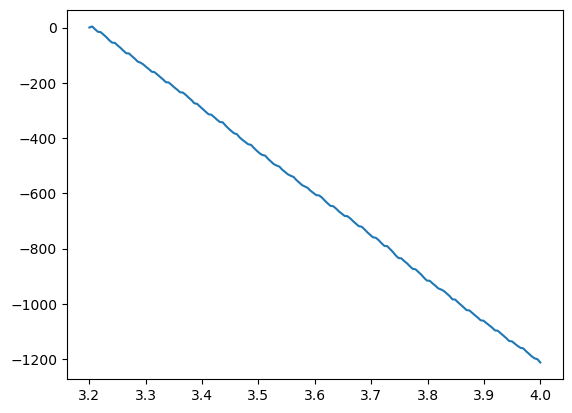

In [209]:
plt.plot(p22_pos, p22_y)
plt.show()

In [202]:
res = stats.linregress(p11_x[6:-6], p11_y[6:-6])
print(1/res.slope)
res = stats.linregress(p12_x[6:-6], p12_y[6:-6])
print(1/res.slope)
res = stats.linregress(p21_x[6:-6], p21_y[6:-6])
print(1/res.slope)
res = stats.linregress(p22_x[6:-6], p22_y[6:-6])
print(1/res.slope)

-0.0001762584995173586
-0.00032291713121690885
-0.00031744259042174554
-0.0006505773525346399


In [63]:
opt_rate = 1
align_2_targets_at_once_cr_y_nonlinear("conex1", "conex2", camera1, camera2, 4, 
                               opt_rate, p_arrays, fit_thresh=10)

mcd1 old position: 3.106687
mcd2 old position: 3.59906
Predicted score: [0.24243076]
mcd1_move_y: 3.167054372998672
mcd2_move_y: 3.5115690108172917
3.106687
mcd1 new position: 3.167054372998672
mcd2 new position: 3.5115690108172917
new pos: 3.167054372998672, cur_pos: 3.106687
Error:
	Message: VISA Read in CONEX-PP-example.vi->conex-pp.lvclass:Configure.vi->Device_control.vi
	Source:  Failed to execute command "setposition", error originated in control system
forward 1.805734745997344
backwards 1.685
new pos: 3.5115690108172917, cur_pos: 3.59906
Error:
	Message: VISA Read in CONEX-PP-example.vi->conex-pp.lvclass:Configure.vi->Device_control.vi
	Source:  Failed to execute command "setposition", error originated in control system
Predicted y values:
Camera 1: 628.749573292754
Camera 2: 607.4239306785042
Actual y values
Camera 1: 600.671814
Camera 2: 597.551697
obj1: 802.4861220505937
obj2: 89.27042957980919


(3.167054372998672, 3.5115690108172917)

In [249]:
def test_nonlinear_algo(num):
    """
    Tests nonlinear algorithm for how far it's off in the y direction
    """
    
    centroid1_x, centroid1_y = get_centroid(camera1, SHOTS_TO_AVG, TIME_BETWEEN_SHOTS)
    centroid2_x, centroid2_y = get_centroid(camera2, SHOTS_TO_AVG, TIME_BETWEEN_SHOTS)
    
    camera1.set('Target.Y', int(centroid1_y + random.randint(-20, 20)))
    camera2.set('Target.Y', int(centroid2_y + random.randint(-20, 20)))

    obj1 = (camera1.state['Target.Y'] - centroid1_y)**2
    obj2 = (camera2.state['Target.Y'] - centroid2_y)**2
    
    before_obj1 = np.zeros(num)
    before_obj2 = np.zeros(num)
    after_obj1 = np.zeros(num)
    after_obj2 = np.zeros(num)
    for i in range(num):
        centroid1_x, centroid1_y = get_centroid(camera1, SHOTS_TO_AVG, TIME_BETWEEN_SHOTS)
        centroid2_x, centroid2_y = get_centroid(camera2, SHOTS_TO_AVG, TIME_BETWEEN_SHOTS)

        camera1.set('Target.Y', int(centroid1_y + random.randint(-20, 20)))
        camera2.set('Target.Y', int(centroid2_y + random.randint(-20, 20)))

        obj1 = (camera1.state['Target.Y'] - centroid1_y)**2
        obj2 = (camera2.state['Target.Y'] - centroid2_y)**2
        before_obj1[i] = obj1
        before_obj2[i] = obj2
        
        
        align_2_targets_at_once_cr_y('conex1', 'conex2', camera1, camera2, rough_target,
                            opt_rate_thresh, fit='linear', fit_thresh=10)
        
        centroid1_x, centroid1_y = get_centroid(camera1, SHOTS_TO_AVG, TIME_BETWEEN_SHOTS)
        centroid2_x, centroid2_y = get_centroid(camera2, SHOTS_TO_AVG, TIME_BETWEEN_SHOTS)
        obj1 = (camera1.state['Target.Y'] - centroid1_y)**2
        obj2 = (camera2.state['Target.Y'] - centroid2_y)**2
        
        after_obj1[i] = obj1
        after_obj2[i] = obj2
        
    return before_obj1, before_obj2, after_obj1, after_obj2


In [250]:
before_obj1, before_obj2, after_obj1, after_obj2 = test_nonlinear_algo(10)

obj1: 228.0719444065998
obj2: 17.777261583481202
Solving equation Ax=b
A = [[-2054.56596436 -3176.16984079]
 [-1180.25106351 -1596.94606332]]
b = [[-15.102051]
 [  4.216309]]
pos =  [[-0.0802077 ]
 [ 0.05663868]]
Opt rate: 1
mcd1_move_y: -0.08020769962915968
mcd2_move_y: 0.05663867795337786
3.431606
mcd1 new position: 3.3513983003708403
mcd2 new position: 4.202244677953378
new pos: 3.3513983003708403, cur_pos: 3.431606
Error:
	Message: VISA Read in CONEX-PP-example.vi->conex-pp.lvclass:Configure.vi->Device_control.vi
	Source:  Failed to execute command "setposition", error originated in control system
Error:
	Message: VISA Read in CONEX-PP-example.vi->conex-pp.lvclass:Configure.vi->Device_control.vi
	Source:  Failed to execute command "setposition", error originated in control system
new pos: 4.202244677953378, cur_pos: 4.145606
forward 1.798277355906757
backwards 1.685
obj1: 293.4977146506232
obj2: 144.996349522248
obj1: 270.3639946770026
obj2: 136.71324669313654
Solving equation Ax=b

Error:
	Message: VISA Read in CONEX-PP-example.vi->conex-pp.lvclass:Configure.vi->Device_control.vi
	Source:  Failed to execute command "setposition", error originated in control system
forward 1.7157554583283892
backwards 1.685
Error:
	Message: VISA Read in CONEX-PP-example.vi->conex-pp.lvclass:Configure.vi->Device_control.vi
	Source:  Failed to execute command "setposition", error originated in control system
new pos: 4.272615375883744, cur_pos: 4.276129
obj1: 71.2872209669759
obj2: 7.042054693968951
--------------------
Moving to fine alignment
--------------------
new pos: 3.262899, cur_pos: 3.261899
Error:
	Message: VISA Read in CONEX-PP-example.vi->conex-pp.lvclass:Configure.vi->Device_control.vi
	Source:  Failed to execute command "setposition", error originated in control system
forward 1.6869999999999994
backwards 1.685
new pos: 3.26382, cur_pos: 3.26282
Error:
	Message: VISA Read in CONEX-PP-example.vi->conex-pp.lvclass:Configure.vi->Device_control.vi
	Source:  Failed to exec

new pos: 3.164218, cur_pos: 3.163218
Error:
	Message: VISA Read in CONEX-PP-example.vi->conex-pp.lvclass:Configure.vi->Device_control.vi
	Source:  Failed to execute command "setposition", error originated in control system
forward 1.6869999999999994
backwards 1.685
new pos: 3.16514, cur_pos: 3.16414
Error:
	Message: VISA Read in CONEX-PP-example.vi->conex-pp.lvclass:Configure.vi->Device_control.vi
	Source:  Failed to execute command "setposition", error originated in control system
forward 1.6869999999999994
backwards 1.685
new pos: 3.164218, cur_pos: 3.165061
Error:
	Message: VISA Read in CONEX-PP-example.vi->conex-pp.lvclass:Configure.vi->Device_control.vi
	Source:  Failed to execute command "setposition", error originated in control system
[3.163218, 3.164218, 3.165218]
[25.57108417 22.64428416 36.75006804]
obj1: 349.22949590848873
obj2: 373.9162430433952
Solving equation Ax=b
A = [[-2054.56596436 -3176.16984079]
 [-1180.25106351 -1596.94606332]]
b = [[-18.687683]
 [ 19.336914]]
pos

Error:
	Message: VISA Read in CONEX-PP-example.vi->conex-pp.lvclass:Configure.vi->Device_control.vi
	Source:  Failed to execute command "setposition", error originated in control system
Error:
	Message: VISA Read in CONEX-PP-example.vi->conex-pp.lvclass:Configure.vi->Device_control.vi
	Source:  Failed to execute command "setposition", error originated in control system
new pos: 4.381580446019595, cur_pos: 4.367112
forward 1.7139368920391913
backwards 1.685
obj1: 42.81083591400112
obj2: 5.709251475216063
--------------------
Moving to fine alignment
--------------------
new pos: 3.108667, cur_pos: 3.107667
Error:
	Message: VISA Read in CONEX-PP-example.vi->conex-pp.lvclass:Configure.vi->Device_control.vi
	Source:  Failed to execute command "setposition", error originated in control system
forward 1.6869999999999994
backwards 1.685
new pos: 3.1095889999999997, cur_pos: 3.108589
Error:
	Message: VISA Read in CONEX-PP-example.vi->conex-pp.lvclass:Configure.vi->Device_control.vi
	Source:  F

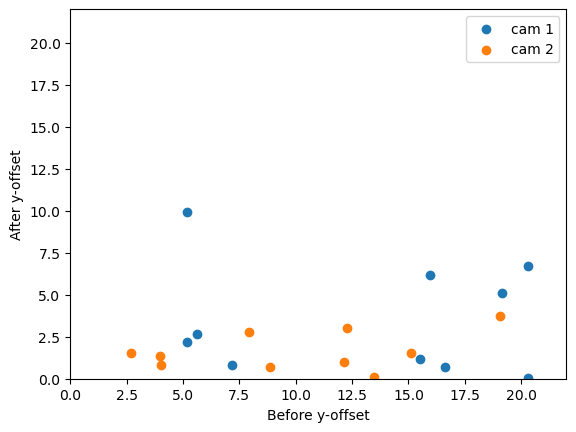

In [253]:
plt.scatter(np.sqrt(before_obj1), np.sqrt(after_obj1), label="cam 1")
plt.scatter(np.sqrt(before_obj2), np.sqrt(after_obj2), label="cam 2")
plt.xlim(0, 22)
plt.ylim(0, 22)
plt.xlabel("Before y-offset")
plt.ylabel("After y-offset")
plt.legend()

In [254]:
for b1, b2, a1, a2 in zip(before_obj1, before_obj2, after_obj1, after_obj2):
    print(f"Camera 1 before: {b1}, Camera 1 after: {a1}")
    print(f"Camera 2 before: {b2}, Camera 2 after: {a2}")

Camera 1 before: 240.03813073089535, Camera 1 after: 1.4177045742758678
Camera 2 before: 16.01269851856878, Camera 2 after: 1.7749566756249506
Camera 1 before: 411.5568915282264, Camera 1 after: 44.726735718025346
Camera 2 before: 7.31381722164871, Camera 2 after: 2.395276238224137
Camera 1 before: 413.0292065344007, Camera 1 after: 0.004639653225004679
Camera 2 before: 150.44854946800982, Camera 2 after: 9.21032059220102
Camera 1 before: 26.78492042222545, Camera 1 after: 98.31525631402542
Camera 2 before: 78.36204679075517, Camera 2 after: 0.4801547566240577
Camera 1 before: 26.887678320889147, Camera 1 after: 4.7815519289759
Camera 2 before: 181.7411356995995, Camera 2 after: 0.015336345599993279
Camera 1 before: 253.96887683280067, Camera 1 after: 37.98438094360876
Camera 2 before: 62.77545022521579, Camera 2 after: 7.7724031374091584
Camera 1 before: 366.23969601209933, Camera 1 after: 25.787668360335783
Camera 2 before: 363.00434844493003, Camera 2 after: 14.014016860899732
Camer

In [164]:
# we need to make a steps/pixel with respect to position to build a model for conex motor vs absolute position
def measure_pixels_wrt_steps(mcd_main_name, mcd_support_name, camera, min_mcd_pos, max_mcd_pos, step_size,
                            support_steps_per_pixel=1, buffer=100):
    """
    Measures the relative move in pixels as a function of mcd position.
    The reason we need this is because the conex motors do not move the camera
    linearly with respect to position
    However, even with large moves, the conex always goes back to the same position
    meaning the function mapping pixels (which is a proxy for angle) to position will be reliable
    I suspect that the length of the motor sticking out is what is nonlinear
    
    To start building the model, the mcd_main must start from min_mcd_pos
    
    mcd_main: the name of the mcd you want to make the model for
    mcd_support: if the laser beam goes off the screen, you move mcd_support to get it back
    camera: camera to measure on
    min_mcd_pos: minimum position to measure to
    max_mcd_pos: maximum position to measure to
    step_size: granularity of measurement
    support_steps_per_pixel: an estimate of the steps_per_pixel of the support camera
    buffer: amount of pixels of buffer to give before moving the support camera to get 
    """
    cam_width = camera.get('ROI.Width')
    cam_height = camera.get('ROI.Height')
    
    # Check to make sure mcd_main at min_mcd_pos
    mcd_main = mcd_dict[mcd_main_name]
    mcd_support = mcd_dict[mcd_support_name]
    
    if abs(mcd_main['device'].state[mcd_main['alias']] - min_mcd_pos) > 0.001:
        print("Move mcd_main to starting position")
        return
    
    pos_arr = np.linspace(min_mcd_pos, max_mcd_pos, int((max_mcd_pos - min_mcd_pos)/step_size) + 1)
    pixels_x_arr = np.zeros(pos_arr.shape)
    pixels_y_arr = np.zeros(pos_arr.shape)
    
    prev_x, prev_y = get_centroid(camera, SHOTS_TO_AVG, 1) # 1s between shots
    pixels_x_arr[0], pixels_y_arr[0] = 0, 0
    
    # Scan from min to max position
    for i, pos in zip(range(1, len(pos_arr)), pos_arr[1:]):
        conex_move_hysteresis(mcd_main_name, pos, CONEX_HYSTERESIS_SIZE)
        current_x, current_y = get_centroid(camera, SHOTS_TO_AVG, 1)
        pixels_x_arr[i] = current_x - prev_x + pixels_x_arr[i-1]
        pixels_y_arr[i] = current_y - prev_y + pixels_y_arr[i-1]
        
        print(current_x, current_y)
        
        # Check if we're at the top or bottom of screen
        if cam_height - current_y < buffer:
            # Move the beam up to top of screen (closer to coordinate of 0)
            pixels_to_move = -cam_height + 2 * buffer
            steps_to_move = pixels_to_move * support_steps_per_pixel * 0.8
            # 0.8 is arbitrary safety factor
            cur_sup_pos = mcd_support['device'].state[mcd_support['alias']]
            conex_move_hysteresis(mcd_support_name, steps_to_move + cur_sup_pos, CONEX_HYSTERESIS_SIZE)
            
        if current_y < buffer:
            # Move the beam down to bottom of screen (away from coordinate of 0)
            pixels_to_move = cam_height - 2 * buffer
            steps_to_move = pixels_to_move * support_steps_per_pixel * 0.8
            # 0.8 is arbitrary safety factor
            cur_sup_pos = mcd_support['device'].state[mcd_support['alias']]
            conex_move_hysteresis(mcd_support_name, steps_to_move + cur_sup_pos, CONEX_HYSTERESIS_SIZE)
            
        # Update previous position of beam in case we made a move
        prev_x, prev_y = get_centroid(camera, SHOTS_TO_AVG, 1) # 1s between shots
        
    return pos_arr, pixels_x_arr, pixels_y_arr
        
        
            
    
    

In [184]:
conex_move_hysteresis("conex2", 3.4, CONEX_HYSTERESIS_SIZE)

pos_arr, pixels_x_arr, pixels_y_arr = measure_pixels_wrt_steps("conex2", "conex1", 
            camera2, 3.4, 4.4, 0.02, support_steps_per_pixel=mcd_dict['conex1']['calib_cam2'], buffer=200)

new pos: 3.4, cur_pos: 3.400027
Error:
	Message: VISA Read in CONEX-PP-example.vi->conex-pp.lvclass:Configure.vi->Device_control.vi
	Source:  Failed to execute command "setposition", error originated in control system
new pos: 3.42, cur_pos: 3.400027
Error:
	Message: VISA Read in CONEX-PP-example.vi->conex-pp.lvclass:Configure.vi->Device_control.vi
	Source:  Failed to execute command "setposition", error originated in control system
forward 1.7249459999999992
backwards 1.685
346.068787 735.046753
new pos: 3.44, cur_pos: 3.420218
Error:
	Message: VISA Read in CONEX-PP-example.vi->conex-pp.lvclass:Configure.vi->Device_control.vi
	Source:  Failed to execute command "setposition", error originated in control system
forward 1.724563999999999
backwards 1.685
348.653473 704.313965
new pos: 3.46, cur_pos: 3.440211
Error:
	Message: VISA Read in CONEX-PP-example.vi->conex-pp.lvclass:Configure.vi->Device_control.vi
	Source:  Failed to execute command "setposition", error originated in control sys

backwards 1.685
496.410278 378.14859
new pos: 3.98, cur_pos: 3.960216
Error:
	Message: VISA Read in CONEX-PP-example.vi->conex-pp.lvclass:Configure.vi->Device_control.vi
	Source:  Failed to execute command "setposition", error originated in control system
forward 1.7245679999999997
backwards 1.685
498.136566 349.456635
new pos: 4.0, cur_pos: 3.98011
Error:
	Message: VISA Read in CONEX-PP-example.vi->conex-pp.lvclass:Configure.vi->Device_control.vi
	Source:  Failed to execute command "setposition", error originated in control system
forward 1.7247800000000009
backwards 1.685
502.743835 320.961853
new pos: 4.0200000000000005, cur_pos: 4.00035
Error:
	Message: VISA Read in CONEX-PP-example.vi->conex-pp.lvclass:Configure.vi->Device_control.vi
	Source:  Failed to execute command "setposition", error originated in control system
forward 1.7243000000000013
backwards 1.685
504.249939 288.357452
new pos: 4.04, cur_pos: 4.020343
Error:
	Message: VISA Read in CONEX-PP-example.vi->conex-pp.lvclass

In [185]:
get_centroid(camera2, SHOTS_TO_AVG, 1)

(690.557739, 679.339355)

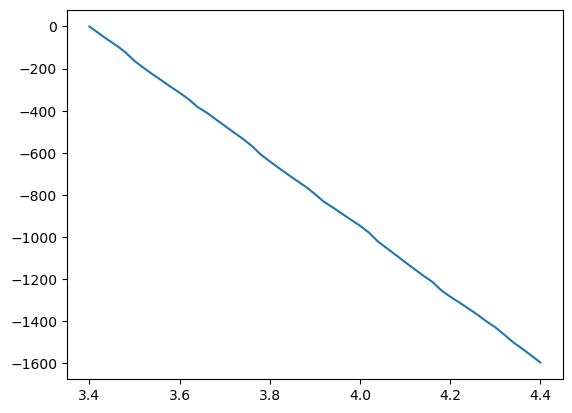

In [186]:
plt.plot(pos_arr, pixels_y_arr)
plt.show()

In [187]:
np.savetxt("conex2_pos_cam2_new.csv", pos_arr, delimiter=",")
np.savetxt("conex2_pixels_y_cam2_new.csv", pixels_y_arr, delimiter=",")
np.savetxt("conex2_pixels_x_cam2_new.csv", pixels_x_arr, delimiter=",")

In [188]:
res = stats.linregress(pos_arr, pixels_y_arr)
print(1/res.slope)

-0.000626195225355997


In [39]:
conex_move_hysteresis("conex1", 2.5, CONEX_HYSTERESIS_SIZE)

pos_arr, pixels_x_arr, pixels_y_arr = measure_pixels_wrt_steps("conex1", "conex2", 
            camera1, 2.5, 3.5, 0.02, support_steps_per_pixel=-0.00032424628, buffer=150)

new pos: 2.5, cur_pos: 2.500014
Error:
	Message: VISA Read in CONEX-PP-example.vi->conex-pp.lvclass:Configure.vi->Device_control.vi
	Source:  Failed to execute command "setposition", error originated in control system


KeyboardInterrupt: 

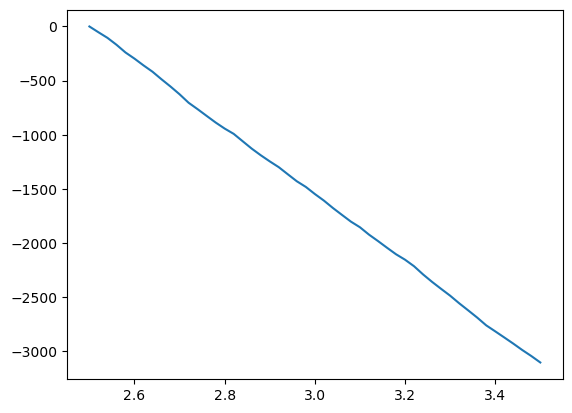

In [53]:
plt.plot(pos_arr, pixels_y_arr)
plt.show()

In [55]:
np.savetxt("conex1_pos.csv", pos_arr, delimiter=",")
np.savetxt("conex1_pixels.csv", pixels_y_arr, delimiter=",")

In [59]:
res = stats.linregress(pos_arr, pixels_y_arr)
print(1/res.slope)

-0.0003208731405705491


In [47]:
print(pixels_y_arr[1:] - pixels_y_arr[:-1])

[ -0.057251    -6.619914   -10.85051433  -8.36005633  -8.68983967
  -1.14977     -7.972565    -9.89201833  -8.561554    -8.36182633
  -1.149231    -8.91917967 -11.496857    -8.60098267  -9.38387033
  -1.31277467  -9.05150333 -11.093994    -8.38192767  -1.514333
  -8.73425333  -7.798645   -10.58447267  -7.70684833  -0.48597167
  -8.613861    -8.812124   -11.74141933  -8.79708367  -0.99756367
  -8.95209733  -7.53189033 -10.44732167  -8.89879367  -0.57982367
  -8.41325933  -9.25953133 -12.100281    -9.51459767  -0.52978
  -9.523829    -8.862147   -10.752945    -4.82130933  -4.36435433
  -8.826129    -9.480672   -11.03412867  -5.56707767  -4.680888
 -10.17779567  -9.833496   -12.07954867  -2.440979    -7.23232067
  -8.47094767  -9.43261733 -10.65661633  -1.53989667  -7.21783467
  -9.902344    -9.36771633 -11.44055167  -1.12103233  -7.63140867
 -10.00244133  -9.14109267  -0.74414067 -10.27237933  -8.85270167
  -8.79577633  -9.190552    -0.61413567 -10.00293     -7.16524267
  -8.43717433  -8

In [27]:
# calib_1_length = 310 + (605 - stage.get('position')) # mm
# calib_2_legnth = 230 + (605 - stage.get('position')) # mm

# align_2_targets_at_once((3,4), ('hex_x', 'hex_y'), False, True, camera, 4, 
#                             opt_rate, 556, 573, 
#                             calib_1_length, calib_2_length, fit='linear', fit_thresh=10)

In [28]:
# calib_1_length = 200 + 270 + 50 #mm
# calib_2_length = 270 + 50 #mm
# opt_rate = 0.5

# align_2_targets_at_once_cr(('CR1', 'CR2'), ('CR3', 'CR4'), False, False, camera2, camera1, 4,
#                             opt_rate, 0, 120, 
#                             calib_1_length, calib_2_length, fit='linear', fit_thresh=10)

In [ ]:
#this
#upstream is axicon, downstream is picos
# This is the cell that does the actual aligning

# Change these each time you run to the values in LPmode focal scan
obj_target = 9 # How accurate, in pixels^2 you want to align to
obj_rate = 0.8 # Gain, you shouldn't have to change this, but if alignment is erratic, you can lower this

# (3,4) are the picos and (hex_x, hex_y) are the axicon motors
# Picos should correspond to crosshair 1, axicon should correspond to crosshair 2
# Make sure that crosshair 1 is set at the downstream position, 
# crosshair 2 is upstream position
align_2_targets((3,4), ('hex_x', 'hex_y'), False, True, camera, obj_target, 
                    obj_rate, fit='linear', fit_thresh=10)

print("Finished aligning")

In [ ]:
# target_num = 2
# move_onto_target(camera, 4, 0.5, 1, 2, target_num, fit='linear', 
#                      fine_thresh=10, hexapod_flag=False, verbose=True)

In [ ]:
# # only run this block if you want to close
# camera.unsubscribe_var_values()
# camera.close()

# picos.unsubscribe_var_values()
# picos.close()

# hexapod.unsubscribe_var_values()
# hexapod.close()

# stage.unsubscribe_var_values()
# stage.close()

In [7]:
def conex_hysteresis_test(mcd_name, camera, pos_min, pos_max, n_points):
    """
    Goes from pos_min to pos_max to pos_min again to test hysteresis
    n_points in both directions
    Plots conex position vs centroid x
    """
    points_to_test_fwd = np.linspace(pos_min, pos_max, n_points)
    points_to_test_back = np.linspace(pos_max, pos_min, n_points)
    actual_pos_fwd = np.zeros(n_points)
    actual_pos_back = np.zeros(n_points)
    centroid_fwd, centroid_back = np.zeros(n_points), np.zeros(n_points)

    conex = mcd_dict[mcd_name]
    print(conex)

    # forward
    for i, p in enumerate(points_to_test_fwd):
        conex_move_hysteresis(mcd_name, p, CONEX_HYSTERESIS_SIZE)
        actual_pos_fwd[i] = conex['device'].get(conex['name'])
        centroids = []
        for j in range(3):
            centroids.append(camera.get('Centroidx'))
            time.sleep(1)
        centroid_fwd[i] = np.mean(np.array(centroids))

        # backward
    for i, p in enumerate(points_to_test_back):
        conex_move_hysteresis(mcd_name, p, CONEX_HYSTERESIS_SIZE)
        print("done moving")
        actual_pos_back[i] = conex['device'].get(conex['name'])
        centroids = []
        for j in range(3):
            centroids.append(camera.get('Centroidx'))
            time.sleep(1)
        centroid_back[i] = np.mean(np.array(centroids))

    with open('./calibration/conex-pp-fwd-4in.txt', 'w') as f:
        f.write("position_to_test,actual_pos,centroid_x\n")
        for test_p, actual_p, centroid_x in zip(points_to_test_fwd, actual_pos_fwd, centroid_fwd):
            f.write(f"{test_p},{actual_p},{centroid_x}\n")

    with open('./calibration/conex-pp-back-4in.txt', 'w') as f:
        f.write("position_to_test,actual_pos,centroid_x\n")
        for test_p, actual_p, centroid_x in zip(points_to_test_back, actual_pos_back, centroid_back):
            f.write(f"{test_p},{actual_p},{centroid_x}\n")       


    # plot
    plt.plot(points_to_test_fwd, centroid_fwd, label='forward', color='red')
    plt.plot(points_to_test_back, centroid_back, label='backward', color='blue')
    plt.xlabel('Conex position')
    plt.ylabel('Camera centroid x')
    plt.legend()
    plt.savefig('conex_hysteresis_4in.png')
    plt.show()

    delta = centroid_fwd - np.flip(centroid_back)
    plt.scatter(points_to_test_fwd, delta)
    plt.xlabel('Conex position')
    plt.ylabel('Delta centroid x')
    plt.title('Hysteresis difference')
    plt.savefig('conex_hysteresis_delta_4in.png')
    plt.show()

{'device': <geecs_python_api.controls.devices.geecs_device.GeecsDevice object at 0x0000026C1C7D3B50>, 'name': 'position', 'alias': 'position', 'calib': -0.0004842615, 'polyfit': None, 'polyfitfine': None, 'axis': 'x', 'min': 0, 'max': 5}
new pos: 2.9, cur_pos: 2.979935
Error:
	Message: VISA Read in CONEX-PP-example.vi->conex-pp.lvclass:Configure.vi->Device_control.vi
	Source:  Failed to execute command "setposition", error originated in control system
new pos: 2.92, cur_pos: 2.900014
Error:
	Message: VISA Read in CONEX-PP-example.vi->conex-pp.lvclass:Configure.vi->Device_control.vi
	Source:  Failed to execute command "setposition", error originated in control system
forward 1.7249719999999993
backwards 1.685
new pos: 2.94, cur_pos: 2.919908
Error:
	Message: VISA Read in CONEX-PP-example.vi->conex-pp.lvclass:Configure.vi->Device_control.vi
	Source:  Failed to execute command "setposition", error originated in control system
forward 1.7251839999999996
backwards 1.685
new pos: 2.96, cur_p

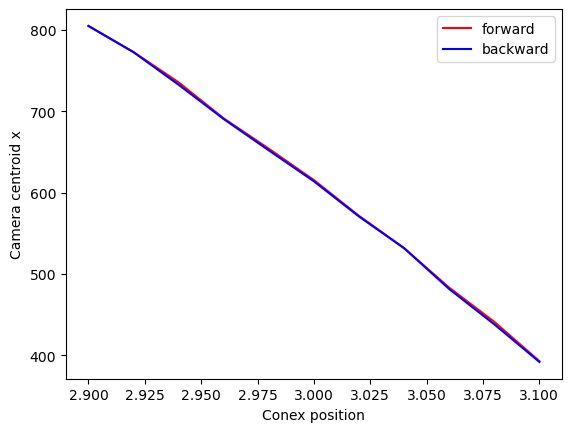

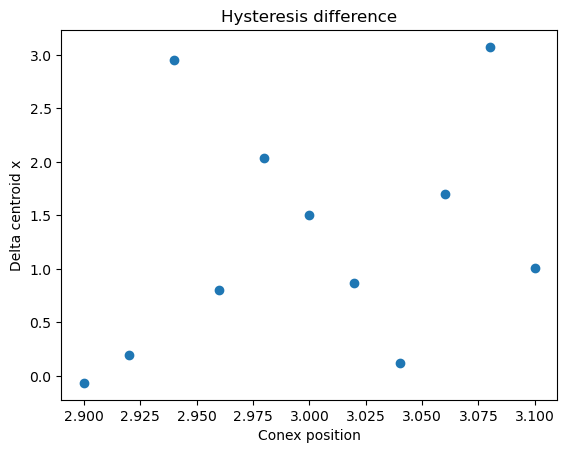

In [12]:
conex_hysteresis_test('conex1', camera1, 2.9, 3.1, 11)

In [19]:
def conex_precision_test(mcd_name, camera, pos_min, pos_max, n_points, eps):
    """
    Generate n_points random locations for the Conex to move to and
    record the difference between the actual conex position
    and the target conex position

    Also looks at the position on the camera

    Difference in points must be greater than eps
    """
    targets = np.zeros(n_points)
    targets[0] = random.random() * (pos_max - pos_min) + pos_min
    for i in range(n_points - 1):
        new_target = random.random() * (pos_max - pos_min) + pos_min
        while abs(new_target - targets[i]) <= eps:
            new_target = random.random() * (pos_max - pos_min) + pos_min
        targets[i+1] = new_target

    conex = mcd_dict[mcd_name]
    camera_x = np.zeros(n_points)
    actual_x = np.zeros(n_points)
    for i, t in enumerate(targets):
        conex_move_hysteresis(mcd_name, t, CONEX_HYSTERESIS_SIZE)
        centroids = []
        for j in range(5):
            centroids.append(camera.get('Centroidx'))
            time.sleep(1)
        camera_x[i] = np.mean(np.array(centroids))
        actual_x[i] = conex['device'].state[conex['alias']]
    
    with open('./calibration/conex-pp-random-4in.txt', 'w') as f:
        f.write("position_to_test,actual_pos,centroid_x\n")
        for test_p, actual_p, centroid_x in zip(targets, actual_x, camera_x):
            f.write(f"{test_p},{actual_p},{centroid_x}\n")
        
    plt.scatter(targets, actual_x)
    plt.xlabel("Target position")
    plt.ylabel("Actual position")
    plt.savefig("conex_precision_4in.png")
    plt.show()

    plt.scatter(targets, actual_x - targets)
    plt.xlabel("Target position")
    plt.ylabel("Residual")
    plt.savefig("conex_precision_residual_4in.png")
    plt.show()

    slope, intercept, _, _, _ = stats.linregress(targets, camera_x)
    fit_x = np.linspace(pos_min, pos_max, 1000)
    fit_y = slope * fit_x + intercept

    plt.scatter(targets, camera_x)
    plt.plot(fit_x, fit_y)
    plt.xlabel("Target position")
    plt.ylabel("Camera position")
    plt.savefig("conex_calibration_4in.png")
    plt.show()

    residuals = camera_x - (targets * slope + intercept)
    plt.scatter(targets, residuals)
    plt.xlabel("Target position")
    plt.ylabel("Camera position")
    plt.savefig("conex_calibration_residuals_4in.png")
    plt.show()


In [14]:
def conex_repeatability_test(mcd_name, camera, position, n_points, x_range, eps):
    """
    Generate n_points random locations for the Conex to move to and
    record the difference between the actual conex position
    and the target conex position

    Also looks at the position on the camera

    Difference in points must be greater than eps
    """
    targets = np.zeros(n_points)
    for i in range(n_points):
        new_target = (-0.5 + random.random()) * x_range + position
        while abs(new_target - position) < eps:
            new_target = (-0.5 + random.random()) * x_range + position
        targets[i] = new_target

    conex = mcd_dict[mcd_name]
    camera_x = np.zeros(n_points)
    actual_x = np.zeros(n_points)
    for i, t in enumerate(targets):
        conex_move_hysteresis(mcd_name, t, CONEX_HYSTERESIS_SIZE)
        conex_move_hysteresis(mcd_name, position, CONEX_HYSTERESIS_SIZE)
        centroids = []
        for j in range(3):
            centroids.append(camera.get('Centroidx'))
            time.sleep(1)
        camera_x[i] = np.mean(np.array(centroids))
        actual_x[i] = conex['device'].state[conex['alias']]
    
    with open('./calibration/conex-pp-repeatability-4in.txt', 'w') as f:
        f.write("position_to_test,actual_pos,centroid_x\n")
        for test_p, actual_p, centroid_x in zip(targets, actual_x, camera_x):
            f.write(f"{test_p},{actual_p},{centroid_x}\n")
        
    plt.scatter(targets, actual_x)
    plt.xlabel("Target position")
    plt.ylabel("Actual position")
    plt.savefig("conex_repeatability_4in.png")
    plt.show()

    plt.scatter(targets, actual_x - position)
    plt.xlabel("Target position")
    plt.ylabel("Residual")
    plt.savefig("conex_repeatability_residuals_4in.png")
    plt.show()

    plt.scatter(targets, camera_x)
    plt.xlabel("Target position")
    plt.ylabel("Camera position")
    plt.savefig("conex_repeatability_camera_4in.png")
    plt.show()



In [20]:
conex_precision_test('conex1', camera1, 2.9, 3.1, 50, 0.002)

new pos: 3.0374168510738446, cur_pos: 3.096418
Error:
	Message: VISA Read in CONEX-PP-example.vi->conex-pp.lvclass:Configure.vi->Device_control.vi
	Source:  Failed to execute command "setposition", error originated in control system


KeyboardInterrupt: 

new pos: 2.96702572017118, cur_pos: 3.062584
Error:
	Message: VISA Read in CONEX-PP-example.vi->conex-pp.lvclass:Configure.vi->Device_control.vi
	Source:  Failed to execute command "setposition", error originated in control system
new pos: 3.0, cur_pos: 2.967037
Error:
	Message: VISA Read in CONEX-PP-example.vi->conex-pp.lvclass:Configure.vi->Device_control.vi
	Source:  Failed to execute command "setposition", error originated in control system
forward 1.7509259999999998
backwards 1.685
new pos: 2.9811962439348396, cur_pos: 2.999928
Error:
	Message: VISA Read in CONEX-PP-example.vi->conex-pp.lvclass:Configure.vi->Device_control.vi
	Source:  Failed to execute command "setposition", error originated in control system
new pos: 3.0, cur_pos: 2.981225
Error:
	Message: VISA Read in CONEX-PP-example.vi->conex-pp.lvclass:Configure.vi->Device_control.vi
	Source:  Failed to execute command "setposition", error originated in control system
forward 1.72255
backwards 1.685
new pos: 3.02288780506313

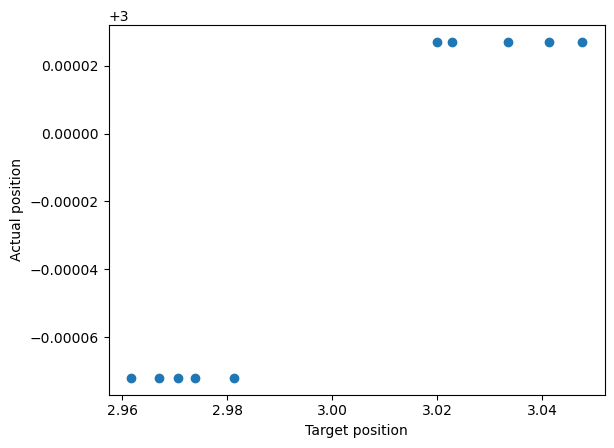

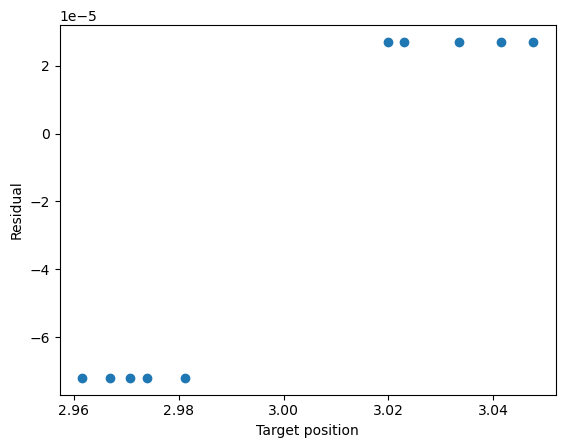

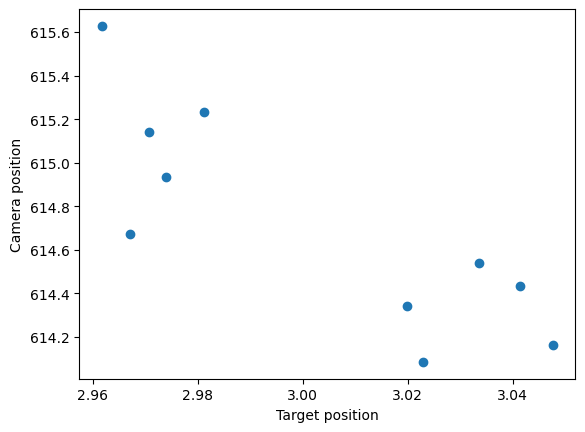

In [17]:
conex_repeatability_test('conex1', camera1, 3.0, 10, 0.1, 0.002)